### Import libraries, Initialise variables

In [1]:
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision
import pandas as pd
from torch import nn
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# variables
learning_rate = 0.001
num_epochs = 10
batch_size = 10

### Prepare the dataset and the dataloader

In [2]:

from utils.dataloader import TrainDataset, AutoEncoder
import os

train_dataset = TrainDataset('./Dataset', (512, 512))

train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size

train_data, test_data = torch.utils.data.random_split(train_dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


### Plot some images

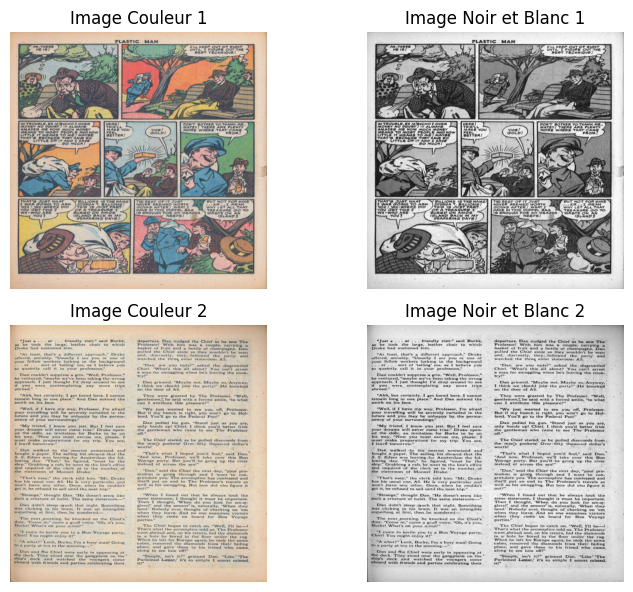

In [3]:
def plot_images(dataset, num_images=2):

    plt.figure(figsize=(8, num_images * 3))

    for i in range(num_images):
        bw_image, color_image = dataset.__getitem__(15*i)

        color_image = (color_image * 127.5 + 127.5).clamp(0, 255).byte()
        bw_image = (bw_image * 127.5 + 127.5).clamp(0, 255).byte()

        color_image = TF.to_pil_image(color_image)
        bw_image = TF.to_pil_image(bw_image)

        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(color_image)
        plt.title(f"Image Couleur {i + 1}")
        plt.axis('off')

        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(bw_image, cmap='gray')
        plt.title(f"Image Noir et Blanc {i + 1}")
        plt.axis('off')

    plt.tight_layout(pad=1.0)
    plt.show()

plot_images(train_dataset)


### Train the model

In [8]:
from tqdm import tqdm

model = AutoEncoder(2)
print("Model created")
MSE = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)

for epoch in range(num_epochs):

    running_loss = 0

    for i, (images_bw, images_color) in enumerate(tqdm(train_loader)):
        #Forward pass
        outputs = model(images_bw)
        loss = MSE(outputs, images_color)

        #backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch} / {num_epochs}], loss : {running_loss/n_total_steps : .3f}")

print("finished training")


Model created


100%|██████████| 67/67 [02:45<00:00,  2.47s/it]


Epoch [0 / 10], loss :  0.414


100%|██████████| 67/67 [02:04<00:00,  1.86s/it]


Epoch [1 / 10], loss :  0.278


100%|██████████| 67/67 [02:14<00:00,  2.00s/it]


Epoch [2 / 10], loss :  0.223


100%|██████████| 67/67 [01:52<00:00,  1.67s/it]


Epoch [3 / 10], loss :  0.174


100%|██████████| 67/67 [02:27<00:00,  2.20s/it]


Epoch [4 / 10], loss :  0.152


100%|██████████| 67/67 [03:01<00:00,  2.71s/it]


Epoch [5 / 10], loss :  0.140


100%|██████████| 67/67 [03:33<00:00,  3.19s/it]


Epoch [6 / 10], loss :  0.132


100%|██████████| 67/67 [03:30<00:00,  3.14s/it]


Epoch [7 / 10], loss :  0.126


100%|██████████| 67/67 [03:29<00:00,  3.12s/it]


Epoch [8 / 10], loss :  0.122


100%|██████████| 67/67 [03:29<00:00,  3.13s/it]

Epoch [9 / 10], loss :  0.119
finished training


### Test the model on some images

Output color shape for sample 1: torch.Size([1, 3, 512, 512])
Output color shape for sample 2: torch.Size([1, 3, 512, 512])
Output color shape for sample 3: torch.Size([1, 3, 512, 512])
Output color shape for sample 4: torch.Size([1, 3, 512, 512])
Output color shape for sample 5: torch.Size([1, 3, 512, 512])


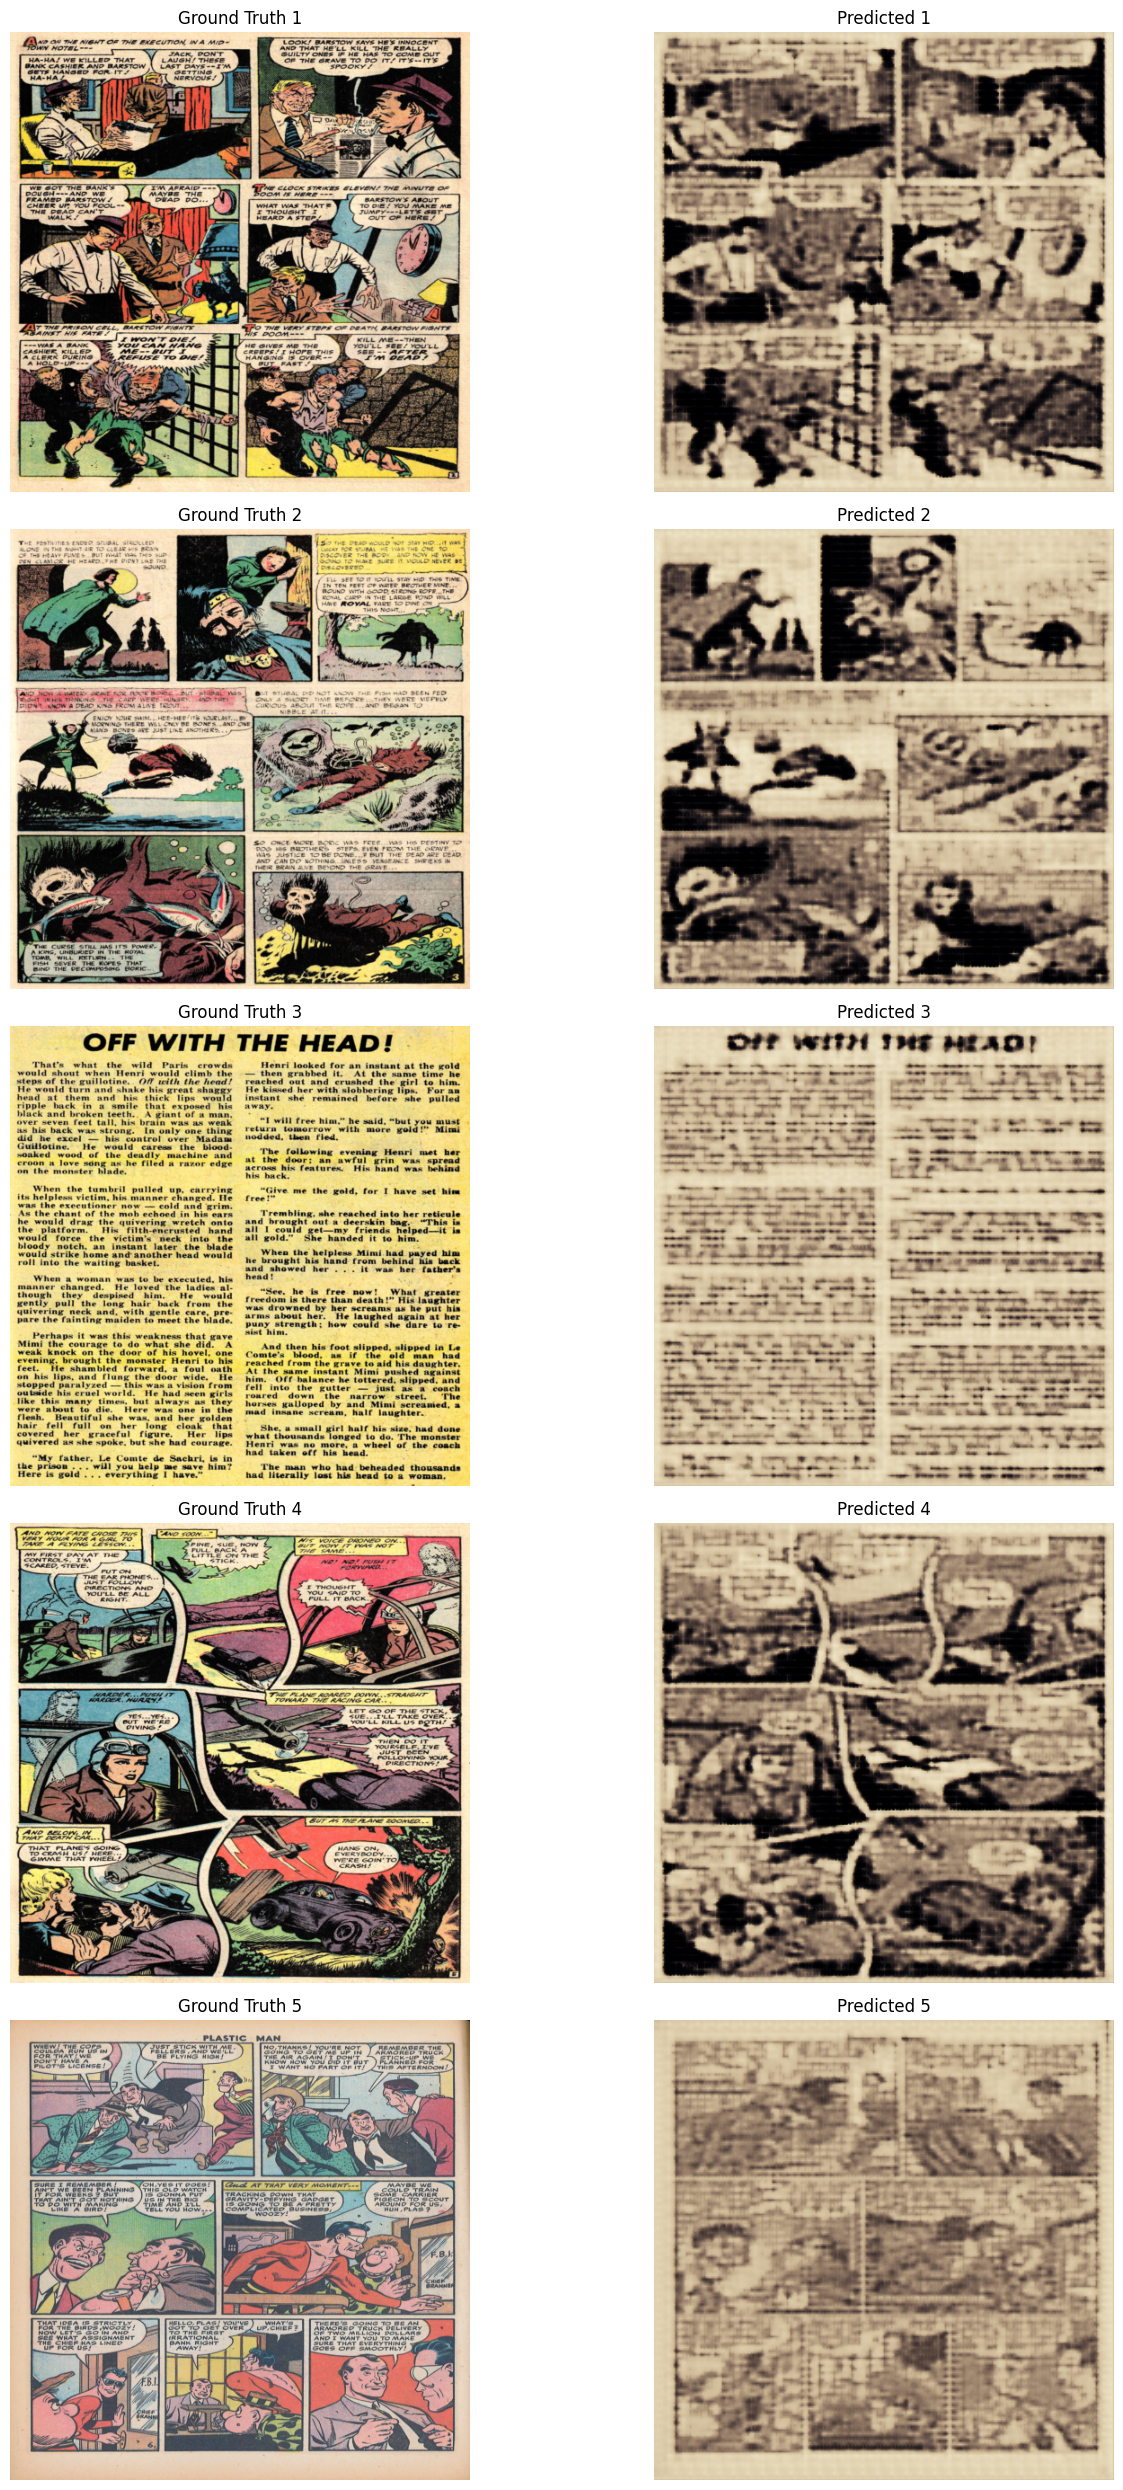

In [10]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch

# Assuming `test_loader` is your test dataset loader and model is your trained model

def plot_multiple_results(model, test_loader, n_samples=5):
    # Set the model to evaluation mode
    model.eval()

    # Create a figure for plotting
    plt.figure(figsize=(15, n_samples * 5))

    # Loop over the first n_samples in the test dataset
    for i, (image_bw, image_color) in enumerate(test_loader):
        if i >= n_samples:
            break

        # Take the first image from the batch
        image_bw = image_bw[0].unsqueeze(0)  # Shape: [1, H, W]
        image_color = image_color[0].unsqueeze(0)  # Shape: [3, H, W]

        # Get the model output
        with torch.no_grad():
            output_color = model(image_bw)

        # Check the shape of the model output
        print(f"Output color shape for sample {i+1}: {output_color.shape}")

        # Squeeze the batch dimension (remove the first dimension)
        output_color = output_color.squeeze(0)  # Shape: [3, H, W]

        # Convert the output and target images back to the appropriate range [0, 255]
        output_color = (output_color * 127.5 + 127.5).clamp(0, 255).byte()
        image_color = (image_color * 127.5 + 127.5).clamp(0, 255).byte()

        # Squeeze the batch dimension for image_color as well
        image_color = image_color.squeeze(0)  # Shape: [3, H, W]

        # Convert images to PIL format
        output_color_pil = TF.to_pil_image(output_color)
        image_color_pil = TF.to_pil_image(image_color)

        # Plot the original and predicted images
        plt.subplot(n_samples, 2, 2 * i + 1)
        plt.imshow(image_color_pil)
        plt.title(f"Ground Truth {i + 1}")
        plt.axis('off')

        plt.subplot(n_samples, 2, 2 * i + 2)
        plt.imshow(output_color_pil)
        plt.title(f"Predicted {i + 1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot multiple results
plot_multiple_results(model, test_loader, n_samples=5)
